In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import cv2

In [18]:
# 3.3.1 Non-linear Filtering
# Non-linear filter operation include
# median: taking the median of the kernel range, this is good for removing shot noise
# atrimmed-mean: taking the mean of the kernel range excluding the min and max values within the kernel range
# domain: with a kernel of weights [0, 1.0], before performing the non-linear filtering process, the weights are in relative distance from the center pixel
# range: with a kernel of weights [0, 1.0], before performing the non-linear filtering process


def median_filter(source: np.ndarray, kernel: np.ndarray = None) -> int:
    """median filter or weighted median filter
    
    Pass in an actual kernel to perform weighted median filter
    """
    if kernel is None:
        return np.median(source).astype("uint8")
    
    assert source.shape == kernel.shape, "kernel and filtering source should be of the same shape"
    return np.round(np.median(source * kernel / np.sum(kernel))).astype("uint8")


def atrimmed_mean_filter(source: np.ndarray, kernel: np.ndarray = None, trim_percent: float = 0.1) -> int:
    """median filter or weighted median filter
    
    Pass in an actual kernel to perform weighted median filter
    """
    
    source = source.copy()
    if kernel is not None:
        assert source.shape == kernel.shape, "kernel and filtering source should be of the same shape"
        source = source * kernel
    
    total = source.size
    start, end = round(total * trim_percent * 0.5), round(total * (1 - trim_percent * 0.5))

    pool = np.sort(source.reshape(total, ))

    return np.mean(pool[start:end+1])


def domain_filter(kernel_size: int, std: float = 1.) -> np.ndarray:
    """ Derive the domain filter weights

    Formula: 
        |  (i - k)^2 + (j - l)^2 |
    exp |- ======================|
        |        2 sigma^2       |
    """
    center = kernel_size // 2
    kernel = np.zeros((kernel_size, kernel_size), dtype=np.float16)

    for i in range(kernel_size):
        for j in range(kernel_size):
            kernel[i, j] = np.exp(-((i - center)**2 + (j - center)**2)/(2*std**2))

    return kernel


def range_filter(source: np.ndarray, std: float = 1.) -> np.ndarray:
    """ Derive the data range filter weights
    
    Formula:
        |  || f(i, j) - f(c, c) ||^2 |
    exp |- ==========================|
        |         2 sigma^2          |
    """
    center = source.shape[0] // 2
    bench = np.full(source.shape, source[center, center], dtype=np.float16)

    return np.exp(-(source - bench)**2/(2*std**2))


def bilateral_filter(source: np.ndarray, reuse: np.ndarray = None, std_color: float = 50, std_space: float = 1.7) -> np.ndarray:
    domain_f = reuse if reuse is not None else domain_filter(source.shape[0], std=std_space)
    range_f = range_filter(source, std=std_color)

    return atrimmed_mean_filter(source, kernel=domain_f * range_f), domain_f


def bilateral_smoothing(image: np.ndarray, ksize: int = 3) -> np.ndarray:
    """Gray Scaled Image bilateral smoothing"""

    from utils.chapter_3_2 import clamp_padding_grayscale

    pad_image = clamp_padding_grayscale(image, kernel_size=ksize)
    h, w = image.shape
    new_image = image.copy()

    domain_f: np.ndarray = None
    for i in range(h):
        for j in range(w):
            new_image[i, j], domain_f = bilateral_filter(pad_image[i:i+ksize, j:j+ksize], reuse=domain_f)

    return new_image

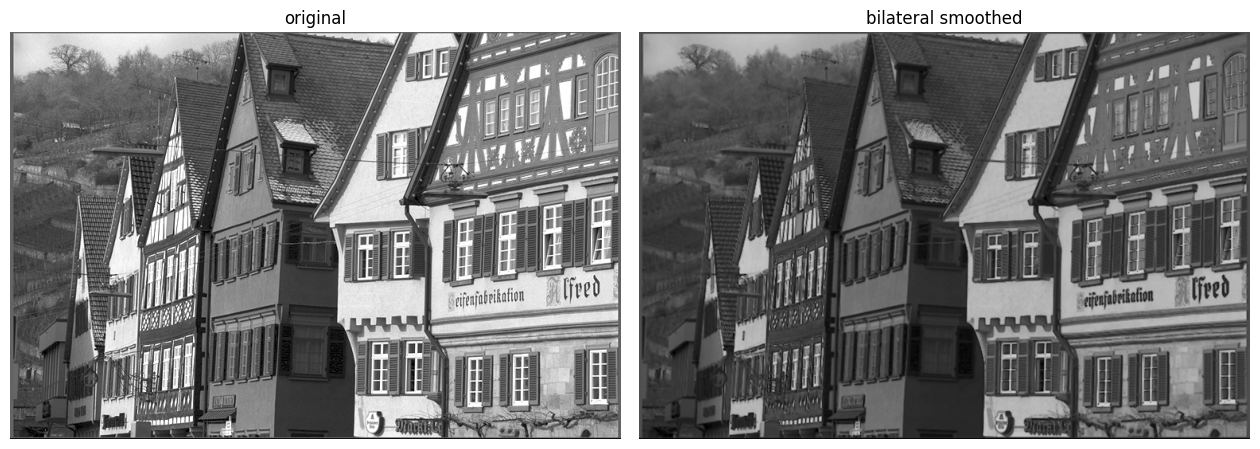

In [19]:
img = cv2.imread("sample/house_gray.jpg", cv2.IMREAD_GRAYSCALE)
out_image = bilateral_smoothing(img)

fig, axis = plt.subplots(1, 2, figsize=(8, 8))

axis[0].imshow(img, cmap='gray', vmin=0, vmax=255)
axis[0].set_title("original")
axis[0].axis("off")
axis[1].imshow(out_image, cmap='gray', vmin=0, vmax=255)
axis[1].set_title("bilateral smoothed")
axis[1].axis("off")

plt.subplots_adjust(wspace=0.03, hspace=0.03)
fig.set_figwidth(16)
plt.show()

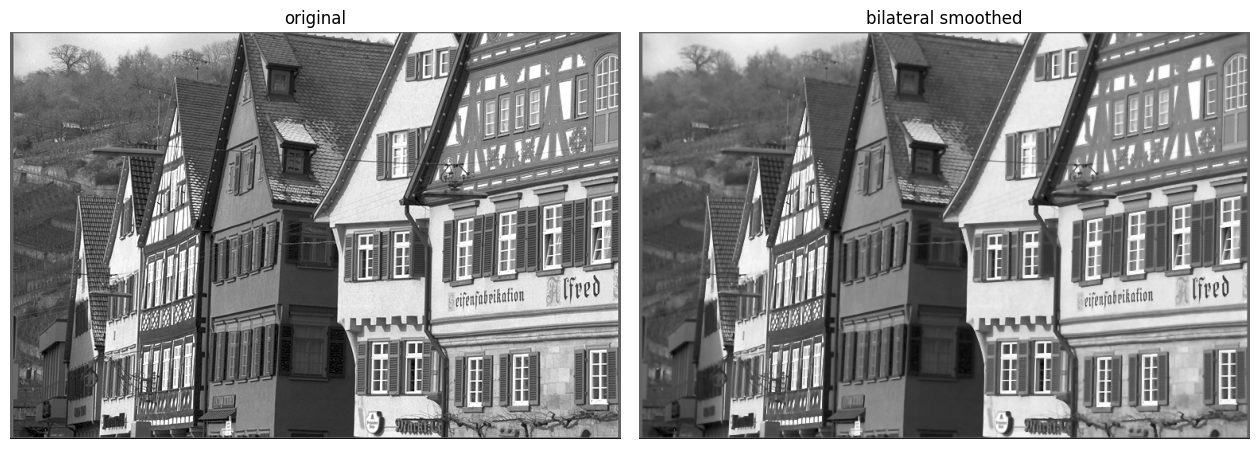

In [20]:
# OpenCV Bilateral Filter implementation
out_image = cv2.bilateralFilter(img, d=5, sigmaSpace=1.7, sigmaColor=50,  borderType=cv2.BORDER_DEFAULT)
fig, axis = plt.subplots(1, 2, figsize=(8, 8))

axis[0].imshow(img, cmap='gray', vmin=0, vmax=255)
axis[0].set_title("original")
axis[0].axis("off")
axis[1].imshow(out_image, cmap='gray', vmin=0, vmax=255)
axis[1].set_title("bilateral smoothed")
axis[1].axis("off")

plt.subplots_adjust(wspace=0.03, hspace=0.03)
fig.set_figwidth(16)
plt.show()

In [ ]:
# 3.3.2 Morphology

